In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
from tqdm.notebook import trange

from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track
from ese2000_dynamical.simulator import Simulator, dynamics_ca

data_path = Path("data")

# device for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


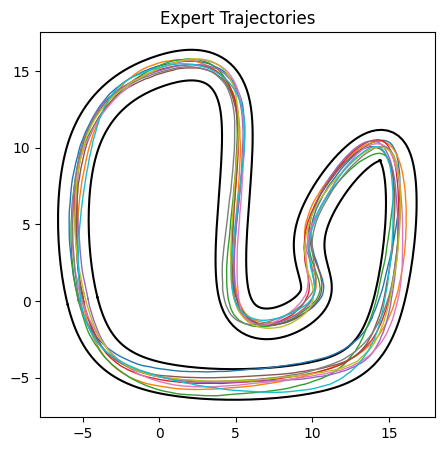

In [3]:
x_expert = np.load(data_path / "states.npy")
u_expert = np.load(data_path / "inputs.npy")
track = load_track(data_path / "track.npz")

plt.figure(figsize=(10, 5))
plt.gca().set_aspect("equal")
track.plot(plt.gca())
plt.title("Expert Trajectories")
for x_ in x_expert:
    plt.plot(x_[:, 0], x_[:, 1], "-", linewidth=1.0)


# Constant Acceleration Model

Let's try see how well the constant acceleration model reflects the behaviour above.

In [4]:
# which trajectory we are using
trajectory_idx = 5
A_ca, B_ca = dynamics_ca(Config.time_step)

t = np.arange(0, Config.duration, Config.time_step)
x_expert = np.load(data_path / "states.npy")[trajectory_idx]
u_expert = np.load(data_path / "inputs.npy")[trajectory_idx]

# compute the single step error
x_predicted = x_expert @ A_ca.T + u_expert @ B_ca.T
mse = np.linalg.norm(x_expert[1:] - x_predicted[:-1], axis=1).mean()
print(f"Single Step MSE: {mse:.4f}")


Single Step MSE: 0.0402


Keep in mind that this is merely the error that we would get from predicting one step forward. However, these errors accumulate over time, so that the final state of the system would be very different.

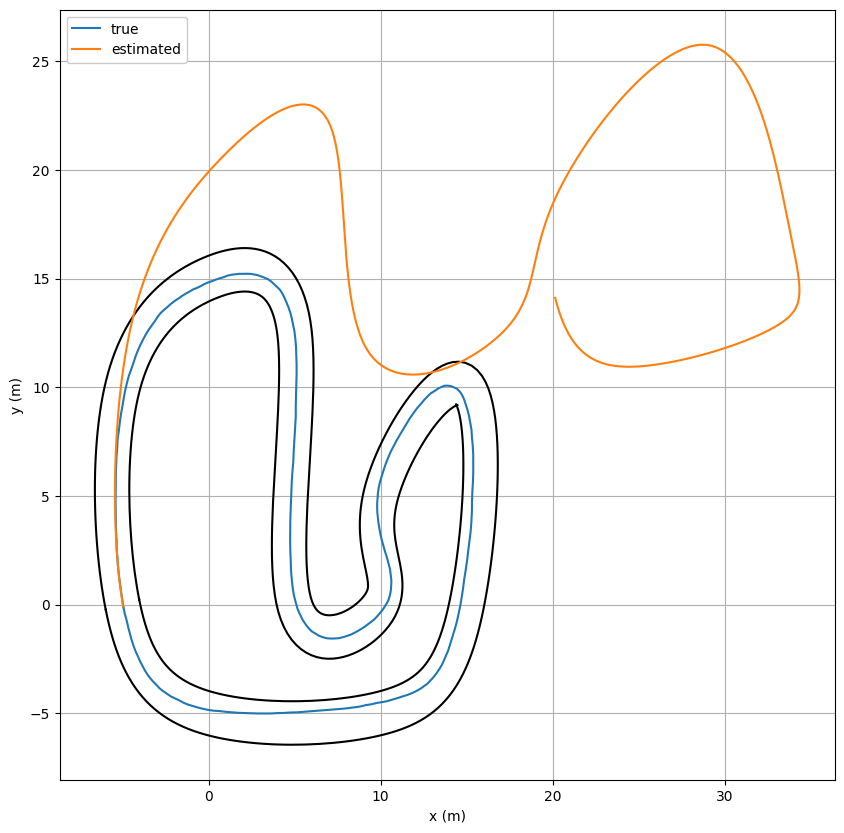

In [5]:
# use the same starting point as the expert
x_estimate = np.zeros((len(t), A_ca.shape[0]))
x_estimate[0] = x_expert[0]

# simulate the trajectory
for i in range(len(t) - 1):
    x_estimate[i + 1] = x_estimate[i] @ A_ca.T + u_expert[i] @ B_ca.T

# TODO compute aggregated MSE

plt.figure(figsize=(10, 10))
track.plot()
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "-", label="true")
plt.plot(x_estimate[:, 0], x_estimate[:, 1], "-", label="estimated")
plt.legend(loc="upper left", framealpha=1.0)
plt.show()


# Learning a linear model
Ok. We probably are expecting too much from a constant acceleration model. Can we find a better model from data?

In [6]:
n_steps = 10000
lr = 1e-3

x = torch.from_numpy(np.load(data_path / "states.npy")).to(device).float()
u = torch.from_numpy(np.load(data_path / "inputs.npy")).to(device).float()

n_states = x.shape[-1]
n_inputs = u.shape[-1]

A_learnt = torch.zeros(n_states, n_states, device=device, requires_grad=True)
B_learnt = torch.zeros(n_states, n_inputs, device=device, requires_grad=True)

optimizer = torch.optim.Adam([A_learnt, B_learnt], lr=lr)
pbar = trange(n_steps)
for i in pbar:
    optimizer.zero_grad()
    x_pred = x[:, :-1] @ A_learnt.T + u[:, :-1] @ B_learnt.T
    loss = (x[:, 1:] - x_pred).pow(2).mean()
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())

np.save(data_path / "A.npy", A_learnt.detach().cpu().numpy())
np.save(data_path / "B.npy", B_learnt.detach().cpu().numpy())


  0%|          | 0/10000 [00:00<?, ?it/s]

Make sure you save the model. Print out the $A$ and $B$ matrices that you learnt.

In [7]:
A_learnt = np.load(data_path / "A.npy")
B_learnt = np.load(data_path / "B.npy")
print("A =")
print(np.array2string(A_learnt, precision=2, suppress_small=True))
print("B =")
print(np.array2string(B_learnt, precision=2, suppress_small=True))


A =
[[ 1.   -0.    0.1  -0.  ]
 [ 0.    1.    0.    0.1 ]
 [ 0.   -0.    0.99 -0.  ]
 [ 0.   -0.    0.    0.99]]
B =
[[ 0.01 -0.  ]
 [ 0.    0.  ]
 [ 0.1  -0.  ]
 [-0.    0.1 ]]


Like with the CA model, let's compute the single step squared error.

In [8]:
# which trajectory we are using
trajectory_idx = 5

t = np.arange(0, Config.duration, Config.time_step)
x_expert = np.load(data_path / "states.npy")[trajectory_idx]
u_expert = np.load(data_path / "inputs.npy")[trajectory_idx]

# compute the single step error
x_predicted = x_expert @ A_learnt.T + u_expert @ B_learnt.T
mse = np.linalg.norm(x_expert[1:] - x_predicted[:-1], axis=1).mean()
print(f"Single Step MSE: {mse:.4f}")


Single Step MSE: 0.0285


We should expect a lower MSE than with the constant acceleration model. Again though, any errors will accumulate over time.

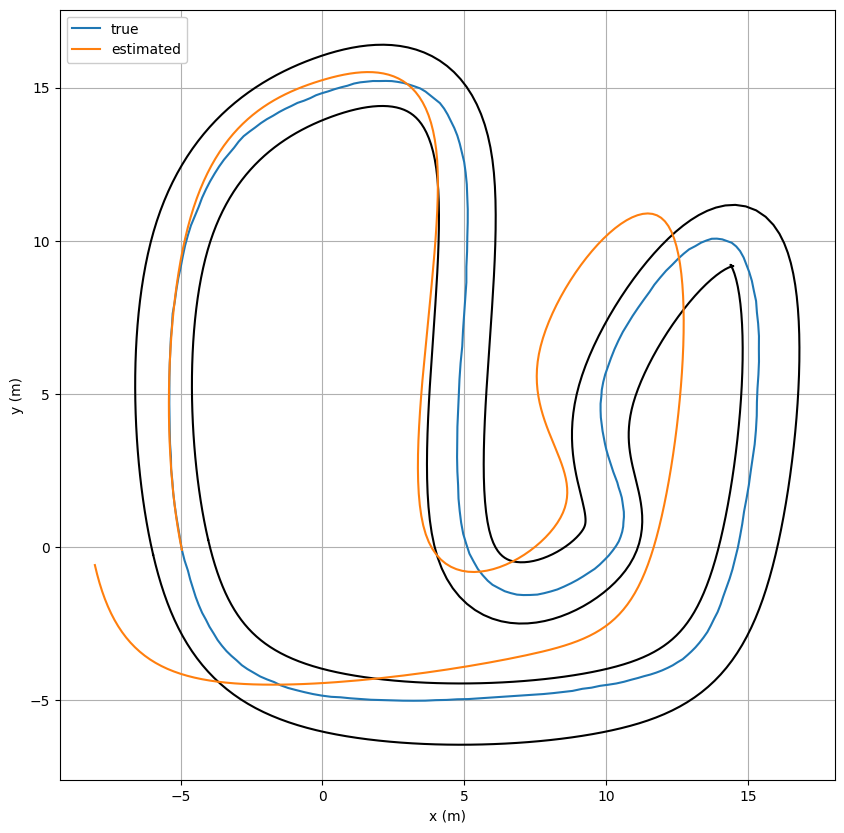

In [9]:
# use the same starting point as the expert
t = np.arange(0, Config.duration, Config.time_step)
x_estimate = np.zeros((len(t), A_learnt.shape[0]))
x_estimate[0] = x_expert[0]

# simulate the trajectory
for i in range(len(t) - 1):
    x_estimate[i + 1] = (
        x_estimate[i] @ A_learnt.T + u_expert[i % len(u_expert)] @ B_learnt.T
    )

plt.figure(figsize=(10, 10))
track.plot()
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "-", label="true")
plt.plot(x_estimate[:, 0], x_estimate[:, 1], "-", label="estimated")
plt.legend(loc="upper left", framealpha=1.0)
plt.show()


This time around our final position is much closer to the expert trajectory but still not perfect. We would deviate further if we did more than 1 lap.

# Control without feedback

In [10]:
import torch

torch.set_float32_matmul_precision("medium")


def rollout(A, B, u, x0):
    x = torch.zeros((len(u) + 1, A.shape[0]), device=A.device)
    x[0] = x0
    for i in range(len(u)):
        x[i + 1] = x[i] @ A.T + u[i] @ B.T
    # return the predicted trajectory
    return x[1:]


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with device:
    A = torch.tensor(np.load(data_path / "A.npy"))
    B = torch.tensor(np.load(data_path / "B.npy"))
    x0 = torch.tensor(x_expert[0]).float()
    x_ref = torch.tensor(x_expert[1:]).float()
    u_naive = torch.zeros(len(x_ref), 2, requires_grad=True).float()
    optimizer = torch.optim.Adam([u_naive], lr=1.0)

pbar = trange(1000)
for _ in pbar:
    optimizer.zero_grad()
    x_pred = rollout(A, B, u_naive, x0)
    # penalize the difference between the predicted and reference trajectory
    loss = (x_pred - x_ref).pow(2).mean()
    # add loss to progress bar
    pbar.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

## Testing our controller

To test your controller we implement a class called `Simulator` for you. By iteratively calling `step` you can simulate on the ground truth system.
`step` takes two arguments:
* an array of length 4 with the current state of the system,
* and an array of length 2 with the control inputs to apply.

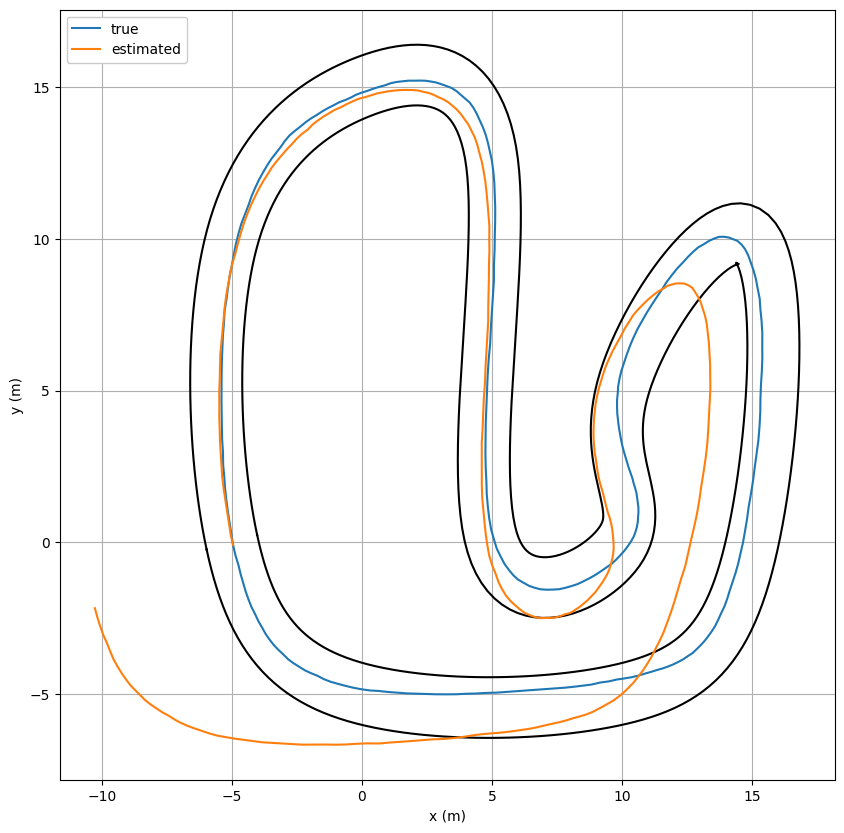

In [12]:
simulator = Simulator()
t = np.arange(0, Config.duration, Config.time_step)
x_esimate = np.zeros_like(x_expert)
# use the starting point as the initial estimate
x_estimate[0] = x_expert[0]
for i in range(len(t) - 1):
    x_estimate[i + 1] = simulator.step(x_estimate[i], u_naive[i].detach().cpu().numpy())

plt.figure(figsize=(10, 10))
track.plot(plt.gca())
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "-", label="true")
plt.plot(
    x_estimate[:, 0],
    x_estimate[:, 1],
    "-",
    label="estimated",
)
plt.legend(loc="upper left", framealpha=1.0)
plt.show()


# MPC Control

Above we repeated the same inputs as the expert, but our trajectory was not the same.
For real systems, it would be impossible to replicate the same conditions. Any errors in the inputs or noise in the system accumulates over time.
However, we can use the matrices $A$ and $B$ we learnt above, to implement a _controller_ that is robust to noise.

In [13]:
def calculate_reference(
    state: npt.NDArray[np.floating],
    x_expert: npt.NDArray[np.floating],
    u_expert: npt.NDArray[np.floating],
    horizon: int,
):
    # find the nearest point in the expert trajectory based on position
    nearest_idx = np.argmin(np.linalg.norm(x_expert[:, :2] - state[:2], axis=1))
    ref_idx = np.arange(nearest_idx + 1, nearest_idx + horizon + 1) % len(x_expert)
    return x_expert[ref_idx], u_expert[ref_idx]


def mpc_controller(
    state: npt.NDArray[np.floating],
    state_matrix: npt.NDArray[np.floating],
    input_matrix: npt.NDArray[np.floating],
    x_ref: npt.NDArray[np.floating],
    u_ref: npt.NDArray[np.floating],
):
    """MPC controller.

    Args:
        x: (4,) array with current state
        A: (4,4) array with state matrix
        B: (4,2) array with input matrix

    Returns:
        u: (M,) array with control input
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    A = torch.from_numpy(state_matrix).to(device)
    B = torch.from_numpy(input_matrix).to(device)

    x_ref_tensor = torch.tensor(x_ref, device=device).float()
    u_ref_tensor = torch.tensor(u_ref, device=device).float()

    # initialize x and u to the reference trajectory
    x0 = torch.tensor(state, device=device).float()
    u = u_ref_tensor.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([u], lr=1.0)

    for _ in range(20):
        optimizer.zero_grad()
        x = rollout(A, B, u, x0)
        loss = (x - x_ref_tensor).pow(2).mean()
        loss.backward()
        optimizer.step()
    return u.detach().cpu().numpy()[0]


  0%|          | 0/299 [00:00<?, ?it/s]

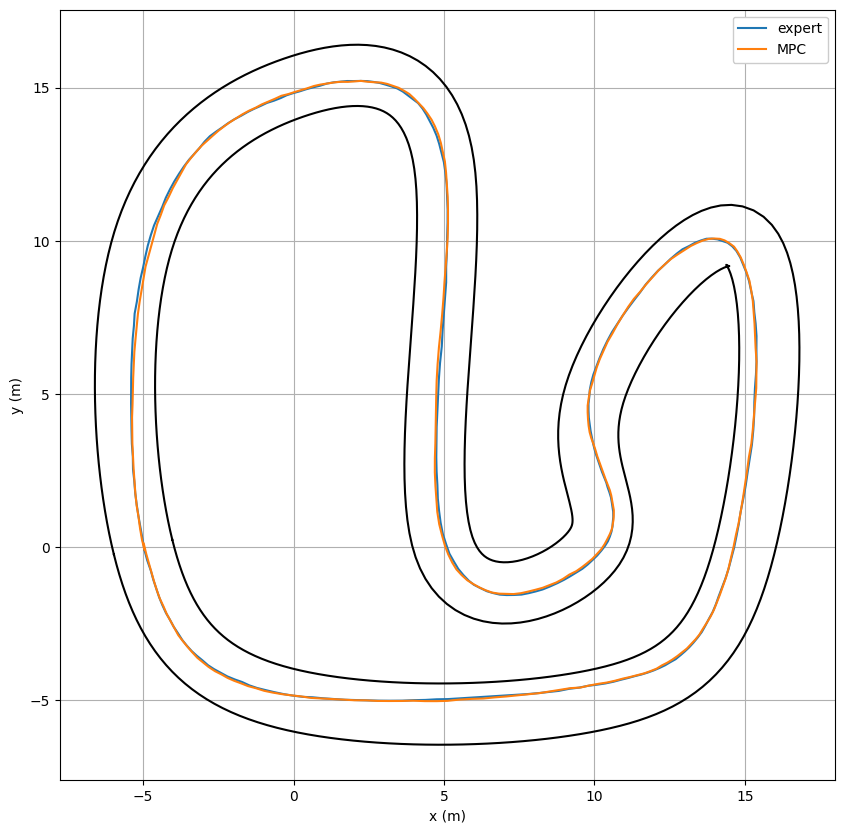

In [14]:
# simulate the trajectory
t = np.arange(0, Config.duration, Config.time_step)
x_mpc = np.zeros((len(t), A_learnt.shape[0]))
# use the same starting point as the expert
x_mpc[0] = x_expert[0]

for i in trange(len(t) - 1):
    x_ref, u_ref = calculate_reference(x_mpc[i], x_expert, u_expert, horizon=10)
    u = mpc_controller(x_mpc[i], A_learnt, B_learnt, x_ref, u_ref)
    x_mpc[i + 1] = simulator.step(x_mpc[i], u)

plt.figure(figsize=(10, 10))
track.plot(plt.gca())
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "-", label="expert")
plt.plot(
    x_mpc[:, 0],
    x_mpc[:, 1],
    "-",
    label="MPC",
)
plt.legend(loc="upper right", framealpha=1.0)
plt.show()


In [15]:
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

trail_length = 10

plt.figure(figsize=(10, 10))
plt.ion()
track.plot(plt.gca())
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="expert")
trail = plt.plot([], [], "-", c="orange", label="MPC")[0]
current_position = plt.plot([], [], "o", c="orange")[0]
plt.legend(loc="upper right", framealpha=1.0)


def animate(i: int):
    trail_idx = slice(max(i - trail_length, 0), i + 1)
    trail.set_data(x_mpc[trail_idx, 0], x_mpc[trail_idx, 1])
    current_position.set_data([x_mpc[i, 0]], [x_mpc[i, 1]])
    return trail, current_position


# html5 video
ani = FuncAnimation(plt.gcf(), animate, frames=len(t), interval=100, blit=True)
display(HTML(ani.to_html5_video()))
plt.close()
